In [34]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from joblib import dump, load
import pandas as pd 
import numpy as np
import datetime 

In [35]:
# DATA PRE-PREPARATION
file_path = '../../../dataset/occurrences.xlsx'

df = pd.read_excel(file_path)
df = df.drop(["rai", "obm_afeto", "qualificacao"], axis=1)

#REMOVING NULL VALUES
df.loc[pd.isnull(df["data"])]
df.loc[pd.isnull(df["naturezas"])]
df.loc[pd.isnull(df["bairro_cidade"])]
df.loc[pd.isnull(df["tr"])]
df.loc[pd.isnull(df["obm_escala"])]
df.loc[pd.isnull(df["sexo"])]

df = df.loc[df["bairro_cidade"] != "(null)"]
df = df.loc[df["recurso"] != "(null)"]
df = df.loc[df["tr"] != "(null)"]
df = df.loc[df["obm_escala"] != "(null)"]
df = df.loc[df["sexo"] != "(null)"]

#TRANSFORMING "data" COLUMN INTO NEW COLUMNS "dia" e "periodo". ALSO TRANSFORMING "tr" COLUMN INTO "tempo_resposta" COLUMN

def day_name(timestamp):
    weekdays = ('Segunda-feira', 'Terça-feira', 'Quarta-feira', 'Quinta-feira', 'Sexta-feira', 'Sábado', 'Domingo')
    return weekdays[timestamp.weekday()]

def period_of_day(timestamp):
    period = ("Madrugada", "Matutino", "Vespertino", "Noturno")
    # Madrugada 00:00 às 05:59
    # Matutino 06:00 às 11:59
    # Vespertino 12:00 às 17:59
    # Noturno 18:00 às 23:59
    if 0 <= timestamp.hour < 6:
        return period[0]
    elif 6 <= timestamp.hour < 12:
        return period[1]
    elif 12 <= timestamp.hour < 18:
        return period[2]
    elif 18 <= timestamp.hour < 24:
        return period[3]



def response_time(response_time):
    # Muito rápido 0 a 10 minutos
    # Rápido 10 a 15 minutos
    # Médio 15 a 20 minutos
    # Longo 20 a 30 minutos
    # Muito longo 30 a 45 minutos
    # Extremamente longo > 45 minutos

    response_time_metric = ("Muito rápido", "Rápido", "Médio", "Longo", "Muito longo", "Extremamente longo")

    if type(response_time) is datetime.time:

        total_time_in_minutes = response_time.hour*60 + response_time.minute + response_time.second/60

        if 0 <= total_time_in_minutes <= 10:
            return response_time_metric[0]
        elif 10 < total_time_in_minutes <= 15:
            return response_time_metric[1]
        elif 15 < total_time_in_minutes <= 20:
            return response_time_metric[2]
        elif 20 <  total_time_in_minutes <= 30:
            return response_time_metric[3]
        elif 30 < total_time_in_minutes <= 45:
            return response_time_metric[4]
        elif total_time_in_minutes > 45:
            return response_time_metric[5]
        
#Lembrar de remover os valores que não são datetime.time do df["tr"]
df.loc[:, "dia"] = df["data"].apply(day_name)
df.loc[:, "periodo"] = df["data"].apply(period_of_day)
df.loc[:, "tempo_resposta"] = df["tr"].apply(response_time)

#REMOVING "DATA" AND "TR" COLUMNS

df = df.drop(["data", "tr"], axis=1)

#Removing None values
df = df.dropna()
df = df.mask(df.eq('None')).dropna()
df = df.astype(str)
df.head()

/home/higoreller/miniconda3/envs/condaenv/lib/python3.9/site-packages/openpyxl/worksheet/_read_only.py:79: UserWarning: Cell F221384 is marked as a date but the serial value -736954.9663425926 is outside the limits for dates. The cell will be treated as an error.
  for idx, row in parser.parse():


,naturezas,bairro_cidade,recurso,obm_escala,sexo,dia,periodo,tempo_resposta
5,RESGATE (3)->EMERGÊNCIA CLÍNICA (304)->ACIDENT...,ZONA RURAL - CATALÃO,UR-181,10º BBM - CATALÃO,MASCULINO,Domingo,Madrugada,Muito rápido
6,RESGATE (3)->ACIDENTE DE TRÂNSITO (301)->CAPOT...,ZONA RURAL - NOVA VENEZA,ABT-26,CAEBM,NÃO-INFORMADO,Domingo,Madrugada,Muito longo
7,RESGATE (3)->ACIDENTE DE TRÂNSITO (301)->CAPOT...,ZONA RURAL - NOVA VENEZA,ASA-74,1º BBM - SETOR CENTRAL,NÃO-INFORMADO,Domingo,Madrugada,Longo
8,RESGATE (3)->ACIDENTE DE TRÂNSITO (301)->CAPOT...,ZONA RURAL - NOVA VENEZA,UR-211,CAEBM,NÃO-INFORMADO,Domingo,Madrugada,Muito longo
9,RESGATE (3)->ACIDENTE DE TRÂNSITO (301)->CAPOT...,ZONA RURAL - NOVA VENEZA,USA-21,BSE,NÃO-INFORMADO,Domingo,Madrugada,Muito longo


In [36]:
def prepareY(df):
    # # Drop rows with no Output values
    # df.dropna(subset=['Var_1'], inplace=True)

    # extract Y and drop from dataframe
    Y = df["tempo_resposta"]

    # encode class values as integers
    yencoder = LabelEncoder()
    yencoder.fit(Y)
    return yencoder.transform(Y)

y = prepareY(df)
df = df.drop(["tempo_resposta"], axis=1)
pd.DataFrame(y).head()

,0
0,3
1,2
2,1
3,2
4,2


In [37]:
numerical_ix = df.select_dtypes(include=['int64', 'float64']).columns
categorical_ix = df.select_dtypes(include=['object', 'bool']).columns

In [38]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder

column_trans = ColumnTransformer(
     [('cat', OrdinalEncoder(),categorical_ix),
      ('num', MinMaxScaler(feature_range=(-1, 1)), numerical_ix)],
     remainder='drop')

column_trans.fit(df)
X = column_trans.transform(df)
pd.DataFrame(X).head()

,0,1,2,3,4,5,6
0,282.0,4768.0,506.0,2.0,1.0,0.0,0.0
1,223.0,4868.0,66.0,54.0,2.0,0.0,0.0
2,223.0,4868.0,240.0,23.0,2.0,0.0,0.0
3,223.0,4868.0,536.0,54.0,2.0,0.0,0.0
4,223.0,4868.0,647.0,53.0,2.0,0.0,0.0


In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
yhot = np_utils.to_categorical(y)
yhot_train = np_utils.to_categorical(y_train)
yhot_test = np_utils.to_categorical(y_test)

In [40]:
# define baseline model
def baseline_model():
	# create model
	model = Sequential()
	# Rectified Linear Unit Activation Function
	model.add(Dense(14, input_dim=7, activation='relu'))
	model.add(Dense(14, activation = 'relu'))
	# Softmax for multi-class classification
	model.add(Dense(6, activation='softmax'))
	# Compile model
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model

# model = baseline_model()
cmodel = KerasClassifier(build_fn=baseline_model, epochs=200, batch_size=100, verbose=1)

/tmp/ipykernel_536/1851177916.py:15: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  cmodel = KerasClassifier(build_fn=baseline_model, epochs=200, batch_size=100, verbose=1)


In [41]:
kfold = KFold(n_splits=3, shuffle=True)

In [42]:
result = cross_val_score(cmodel, X, yhot, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (result.mean()*100, result.std()*100))

Epoch 1/200
2871/2871 [==============================] - 10s 3ms/step - loss: 8.0082 - accuracy: 0.2435
Epoch 2/200
2871/2871 [==============================] - 8s 3ms/step - loss: 2.1063 - accuracy: 0.2521
Epoch 3/200
2871/2871 [==============================] - 10s 3ms/step - loss: 2.0385 - accuracy: 0.2541
Epoch 4/200
2871/2871 [==============================] - 10s 3ms/step - loss: 2.0490 - accuracy: 0.2549
Epoch 5/200
2871/2871 [==============================] - 10s 4ms/step - loss: 2.0201 - accuracy: 0.2558
Epoch 6/200
2871/2871 [==============================] - 8s 3ms/step - loss: 1.9990 - accuracy: 0.2576
Epoch 7/200
2871/2871 [==============================] - 8s 3ms/step - loss: 1.9518 - accuracy: 0.2616
Epoch 8/200
2871/2871 [==============================] - 8s 3ms/step - loss: 1.9461 - accuracy: 0.2608
Epoch 9/200
2871/2871 [==============================] - 7s 2ms/step - loss: 1.9227 - accuracy: 0.2650
Epoch 10/200
2871/2871 [==============================] - 9s 3ms/step

In [43]:
model = baseline_model()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(X_train, yhot_train, validation_split=0.33,
                    epochs=200, batch_size=100, verbose=0)

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


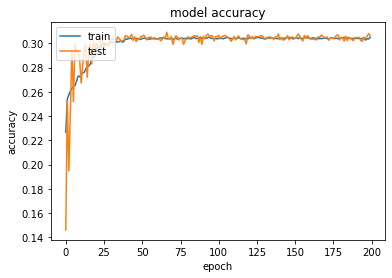

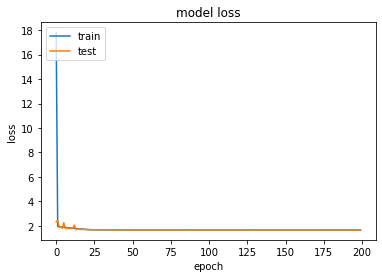

In [44]:
import matplotlib.pyplot as plt
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [45]:
# evaluate the keras model
_, accuracy = model.evaluate(X_test, yhot_test)
print('Accuracy from evaluate: %.2f' % (accuracy*100))

2691/2691 [==============================] - 6s 2ms/step - loss: 1.6676 - accuracy: 0.3067
Accuracy from evaluate: 30.67


In [46]:
predict_x = model.predict(X_test)
pred = np.argmax(predict_x, axis=1)
print(f'Prediction Accuracy: {(pred == y_test).mean() * 100:f}')

Prediction Accuracy: 30.665428
